In [1]:
import os
import tempfile

import anndata
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import scvi
import seaborn as sns
import torch
from scvi.model.utils import mde

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import numpy as np
import pandas as pd
import scanpy as sc
from anndata import AnnData

参考：https://docs.scvi-tools.org/en/stable/tutorials/notebooks/scrna/tabula_muris.html

In [3]:
RNA_counts = pd.read_csv("/home/nas2/biod/hezhentao/FGOT_Project/BMMC_Zhang/BMMC_RNA_data.txt",sep='\t')
activity_counts = pd.read_csv("/home/nas2/biod/hezhentao/FGOT_Project/BMMC_Zhang/atac/BMMC_agg_ATAC_gene_activity_k5_full.txt", sep='\t',index_col=0)

In [4]:
data_path = "/home/nas2/biod/yangchenghui/FGOT-master/data/BMMC_data/"
cell1_cluster = pd.read_csv(data_path+"BMMC_RNA_label.txt", sep='\t')
cell2_cluster = pd.read_csv(data_path+"BMMC_agg_k5_atac_label.txt", sep='\t')
basic_labels1 = np.array(cell1_cluster["x"])
basic_labels2 = np.array(cell2_cluster["metas"])

In [5]:
con_genes = list(set(RNA_counts.index).intersection(set(activity_counts.index)))
len(con_genes)

12429

In [6]:
adata_rna = AnnData(RNA_counts.loc[con_genes].T)
adata_rna.obs['celltype'] = np.array(basic_labels1)
adata_activity = AnnData(activity_counts.loc[con_genes].T)
adata_activity.obs['celltype'] = np.array(basic_labels2)
adata_rna, adata_activity

(AnnData object with n_obs × n_vars = 2379 × 12429
     obs: 'celltype',
 AnnData object with n_obs × n_vars = 1602 × 12429
     obs: 'celltype')

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby("mean_bin")["dispersions"]
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color

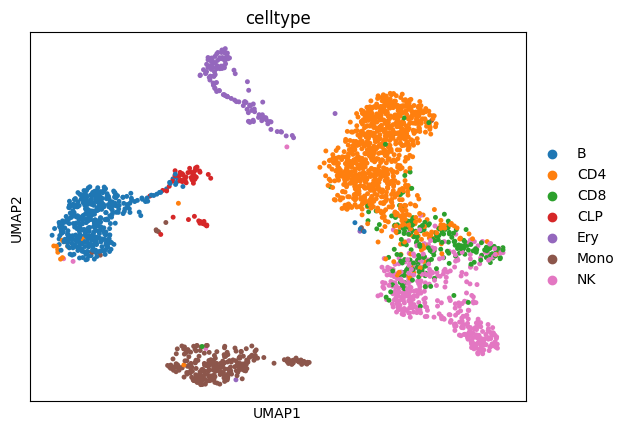

In [7]:
#本身聚类看效果
adata = adata_rna.copy()
# Normalizing to median total counts
sc.pp.normalize_total(adata)
# Logarithmize the data
sc.pp.log1p(adata)
# print(adata)
x1 = adata.X

sc.pp.highly_variable_genes(adata, flavor="seurat", n_top_genes=5000, inplace=True)
adata = adata[:, adata.var.highly_variable]
adata_rna.var['highly_variable'] = adata.var.highly_variable

sc.pp.scale(adata)
sc.tl.pca(adata)
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=40)
sc.tl.umap(adata)
sc.pl.umap(adata, color = ['celltype'])

In [8]:
x1 = pd.DataFrame(x1, columns=RNA_counts.loc[con_genes].index, index = RNA_counts.loc[con_genes].columns)
x1.head()

,DPEP2,C12orf10,SHPRH,ARPC5L,PABPC4,TTC14,NAGA,LPCAT1,TMEM255B,SPAST,...,MRPL1,MED6,DLG4,SLAMF1,PLA2G16,TMEM179B,PAPOLG,COA1,C5orf17,FURIN
AAACCTGAGCTTTGGT.1,0.00000,0.0,0.0,0.00000,0.000000,0.0,0.0,0.00000,0.0,0.0,...,0.0,0.80619,0.0,0.80619,0.0,0.000000,0.0,0.00000,0.0,0.0
AAACCTGCACAGGCCT.1,0.00000,0.0,0.0,0.92368,0.000000,0.0,0.0,0.00000,0.0,0.0,...,0.0,0.00000,0.0,0.00000,0.0,1.134075,0.0,0.92368,0.0,0.0
AAACCTGCATGCCTTC.1,0.00000,0.0,0.0,0.00000,0.616303,0.0,0.0,0.00000,0.0,0.0,...,0.0,0.00000,0.0,0.00000,0.0,0.000000,0.0,0.00000,0.0,0.0
AAACCTGGTGTGTGCC.1,0.83664,0.0,0.0,0.00000,0.000000,0.0,0.0,0.83664,0.0,0.0,...,0.0,0.00000,0.0,0.00000,0.0,0.000000,0.0,0.00000,0.0,0.0
AAACCTGTCCGTCATC.1,0.00000,0.0,0.0,0.00000,0.000000,0.0,0.0,0.00000,0.0,0.0,...,0.0,0.00000,0.0,0.00000,0.0,0.000000,0.0,0.00000,0.0,0.0


In [9]:
sc.tl.rank_genes_groups(adata, 'celltype', method='wilcoxon')
marker_genes = []
for cluster in adata.obs['celltype'].unique():
    markers = adata.uns['rank_genes_groups']['names'][cluster]
    marker_genes.extend(markers[:200])
'Number of marker genes',len(set(marker_genes))

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(

('Number of marker genes', 1010)

In [10]:
hvgs1 = list(set(marker_genes))
len(hvgs1)

1010

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


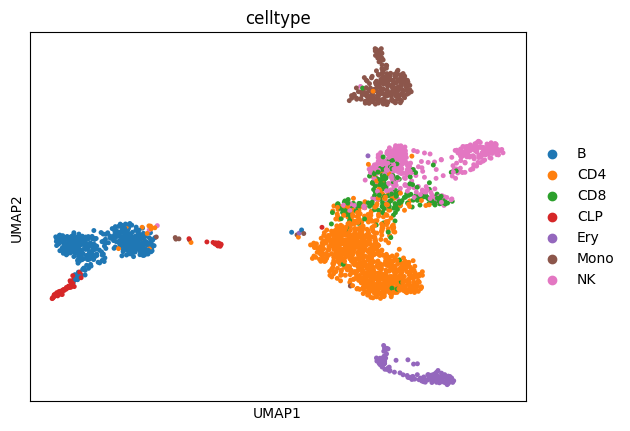

In [11]:
adata = AnnData(x1.loc[:, hvgs1]).copy()
adata.obs['celltype'] = np.array(basic_labels1)

sc.pp.scale(adata)
sc.tl.pca(adata)
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=40)
sc.tl.umap(adata)
sc.pl.umap(adata, color = 'celltype')

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby("mean_bin")["dispersions"]
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color

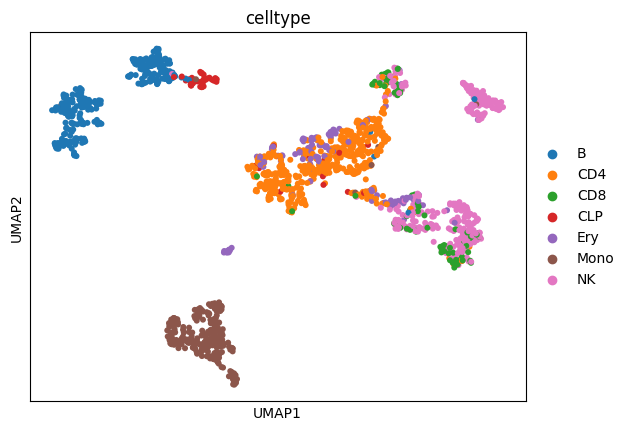

In [12]:
#本身聚类看效果
adata = adata_activity.copy()
# Normalizing to median total counts
sc.pp.normalize_total(adata)
# Logarithmize the data
sc.pp.log1p(adata)

x2 = adata.X

sc.pp.highly_variable_genes(adata, flavor="seurat", n_top_genes=5000, inplace=True)
adata = adata[:, adata.var.highly_variable]
adata_activity.var['highly_variable'] = adata.var.highly_variable

sc.pp.scale(adata)
sc.tl.pca(adata)
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=40)
sc.tl.umap(adata)
sc.pl.umap(adata, color = ['celltype'])

In [13]:
x2 = pd.DataFrame(x2, columns=activity_counts.loc[con_genes].index, index = activity_counts.loc[con_genes].columns)
x2.head()

,DPEP2,C12orf10,SHPRH,ARPC5L,PABPC4,TTC14,NAGA,LPCAT1,TMEM255B,SPAST,...,MRPL1,MED6,DLG4,SLAMF1,PLA2G16,TMEM179B,PAPOLG,COA1,C5orf17,FURIN
Agg_atac_1,0.621474,0.0,0.621474,0.621474,0.000000,0.621474,0.417130,0.417130,0.000000,0.417130,...,0.621474,0.000000,0.417130,0.417130,0.000000,0.417130,0.417130,0.621474,0.0,0.000000
Agg_atac_2,0.000000,0.0,0.686397,0.850394,0.365985,0.559571,0.559571,0.559571,0.365985,0.686397,...,0.000000,0.559571,0.956800,0.559571,0.365985,0.559571,0.000000,0.850394,0.0,0.365985
Agg_atac_3,0.309338,0.0,0.487286,0.698307,0.608310,0.487286,0.309338,0.487286,0.000000,0.698307,...,0.487286,0.000000,0.769071,0.309338,0.309338,0.000000,0.309338,0.487286,0.0,0.000000
Agg_atac_4,0.386510,0.0,0.584245,0.804412,0.386510,0.584245,0.712038,0.386510,0.000000,0.386510,...,0.386510,0.386510,0.875762,0.000000,0.584245,0.584245,0.000000,0.000000,0.0,0.000000
Agg_atac_5,0.515281,0.0,0.638552,0.858233,0.331167,0.515281,0.515281,0.515281,0.000000,0.331167,...,0.331167,0.000000,0.515281,0.331167,0.331167,0.000000,0.331167,0.331167,0.0,0.331167


In [14]:
sc.tl.rank_genes_groups(adata, 'celltype', method='wilcoxon')
marker_genes = []
for cluster in adata.obs['celltype'].unique():
    markers = adata.uns['rank_genes_groups']['names'][cluster]
    marker_genes.extend(markers[:200])
'Number of marker genes',len(set(marker_genes))

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(

('Number of marker genes', 1138)

In [15]:
hvgs2 = list(set(marker_genes))
len(hvgs2)

1138

In [16]:
co = list(set(hvgs1).intersection(set(hvgs2)))
len(co)

216

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


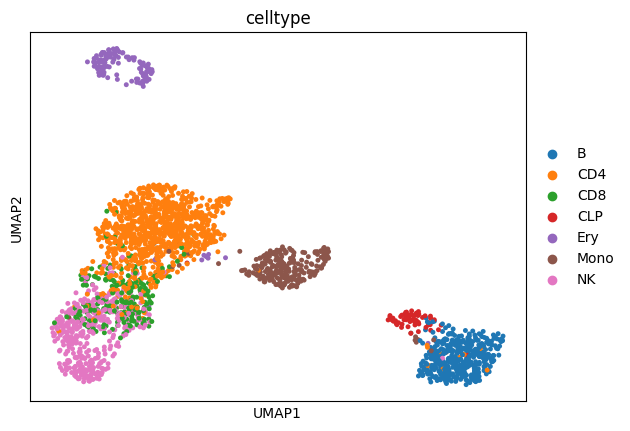

In [17]:
adata = AnnData(x1.loc[:, co]).copy()
adata.obs['celltype'] = np.array(basic_labels1)

sc.pp.scale(adata)
sc.tl.pca(adata)
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=40)
sc.tl.umap(adata)
sc.pl.umap(adata, color = 'celltype')

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


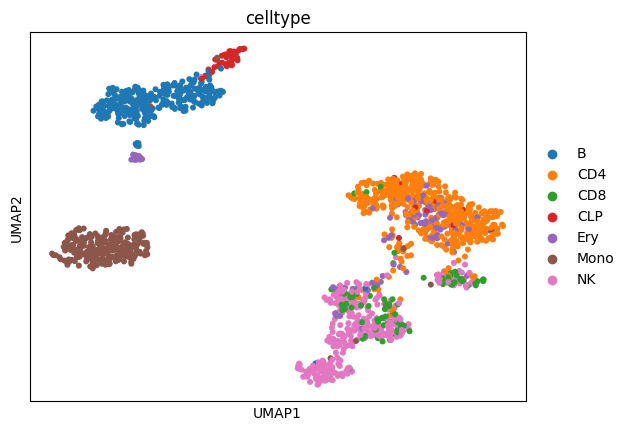

In [18]:
adata = AnnData(x2.loc[:, co]).copy()
adata.obs['celltype'] = np.array(basic_labels2)

sc.pp.scale(adata)
sc.tl.pca(adata)
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=40)
sc.tl.umap(adata)
sc.pl.umap(adata, color = 'celltype')

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Cat

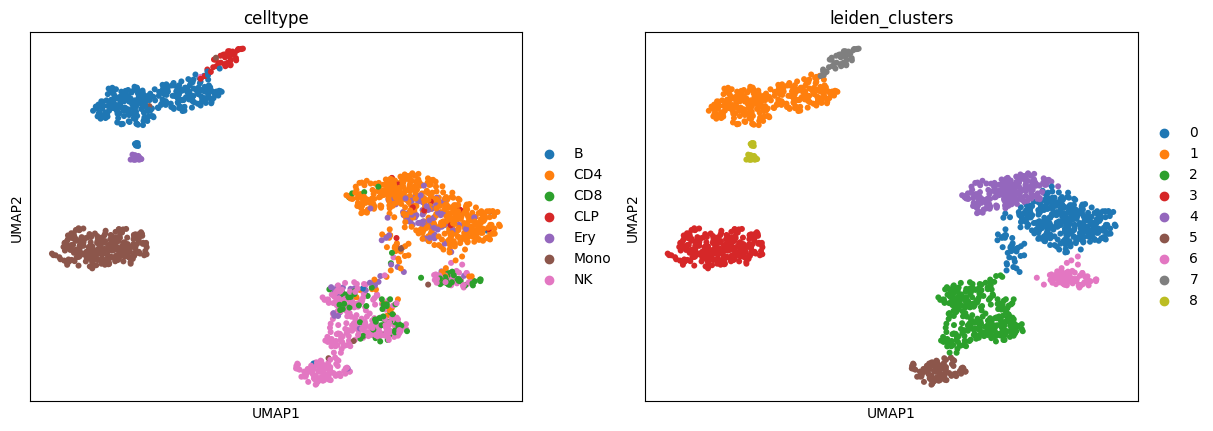

In [19]:
sc.tl.leiden(adata, key_added='leiden_clusters',resolution=0.6)
sc.pl.umap(adata, color = ['celltype','leiden_clusters'])

In [20]:
clu0 = adata[adata.obs["leiden_clusters"]=="0"]
print(len(clu0))
clu0[clu0.obs["celltype"]=="Ery"]

362


View of AnnData object with n_obs × n_vars = 65 × 216
    obs: 'celltype', 'leiden_clusters'
    var: 'mean', 'std'
    uns: 'pca', 'neighbors', 'umap', 'celltype_colors', 'leiden', 'leiden_clusters_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [21]:
clu6 = adata[adata.obs["leiden_clusters"]=="6"]
print(len(clu6))
clu6[clu6.obs["celltype"]=="Ery"]

73


View of AnnData object with n_obs × n_vars = 2 × 216
    obs: 'celltype', 'leiden_clusters'
    var: 'mean', 'std'
    uns: 'pca', 'neighbors', 'umap', 'celltype_colors', 'leiden', 'leiden_clusters_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [22]:
tm_droplet = anndata.AnnData(x2.loc[:, co]).copy()

tm_facs = anndata.AnnData(x1.loc[:, co]).copy()

tm_droplet.obs["batch"] = "activity"
tm_facs.obs["batch"] = "RNA"

tm_droplet, tm_facs

(AnnData object with n_obs × n_vars = 1602 × 216
     obs: 'batch',
 AnnData object with n_obs × n_vars = 2379 × 216
     obs: 'batch')

In [23]:
adata = anndata.concat([tm_facs, tm_droplet])
adata.layers["counts"] = adata.X.copy()
# sc.pp.normalize_total(adata, target_sum=1e4)
# sc.pp.log1p(adata)
adata.raw = adata  # keep full dimension safe
# sc.pp.highly_variable_genes(
#     adata,
#     flavor="seurat_v3",
#     n_top_genes=2000,
#     layer="counts",
#     batch_key="batch",
#     subset=True,
# )

In [24]:
scvi.model.SCVI.setup_anndata(adata, layer="counts", batch_key="batch")

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)


In [25]:
scvi_model = scvi.model.SCVI(adata, n_layers=2, n_latent=30)

In [26]:
scvi_model.train()

Trainer will use only 1 of 10 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=10)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8,9]
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_da

Epoch 1/400:   0%|          | 0/400 [00:00<?, ?it/s]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 2/400:   0%|          | 1/400 [00:00<06:24,  1.04it/s, v_num=1, train_loss_step=119, train_loss_epoch=143]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 3/400:   0%|          | 2/400 [00:01<03:36,  1.84it/s, v_num=1, train_loss_step=117, train_loss_epoch=116]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 4/400:   1%|          | 3/400 [00:01<02:40,  2.47it/s, v_num=1, train_loss_step=106, train_loss_epoch=110]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 5/400:   1%|          | 4/400 [00:01<02:14,  2.94it/s, v_num=1, train_loss_step=102, train_loss_epoch=107]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 6/400:   1%|▏         | 5/400 [00:01<01:59,  3.29it/s, v_num=1, train_loss_step=108, train_loss_epoch=105]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 7/400:   2%|▏         | 6/400 [00:02<01:50,  3.55it/s, v_num=1, train_loss_step=99.9, train_loss_epoch=104]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 8/400:   2%|▏         | 7/400 [00:02<01:45,  3.73it/s, v_num=1, train_loss_step=103, train_loss_epoch=103] 

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 9/400:   2%|▏         | 8/400 [00:02<01:41,  3.86it/s, v_num=1, train_loss_step=102, train_loss_epoch=102]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 10/400:   2%|▏         | 9/400 [00:02<01:38,  3.96it/s, v_num=1, train_loss_step=95.7, train_loss_epoch=101]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 11/400:   2%|▎         | 10/400 [00:03<01:37,  4.02it/s, v_num=1, train_loss_step=93.9, train_loss_epoch=101]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 12/400:   3%|▎         | 11/400 [00:03<01:35,  4.06it/s, v_num=1, train_loss_step=95.5, train_loss_epoch=100]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 13/400:   3%|▎         | 12/400 [00:03<01:34,  4.10it/s, v_num=1, train_loss_step=104, train_loss_epoch=99.8]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 14/400:   3%|▎         | 13/400 [00:03<01:33,  4.12it/s, v_num=1, train_loss_step=107, train_loss_epoch=99.4]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 15/400:   4%|▎         | 14/400 [00:04<01:34,  4.09it/s, v_num=1, train_loss_step=98.5, train_loss_epoch=99] 

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 16/400:   4%|▍         | 15/400 [00:04<01:33,  4.11it/s, v_num=1, train_loss_step=93.9, train_loss_epoch=98.6]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 17/400:   4%|▍         | 16/400 [00:04<01:33,  4.13it/s, v_num=1, train_loss_step=92.5, train_loss_epoch=98.2]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 18/400:   4%|▍         | 17/400 [00:04<01:32,  4.14it/s, v_num=1, train_loss_step=95.7, train_loss_epoch=97.9]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 19/400:   4%|▍         | 18/400 [00:05<01:32,  4.15it/s, v_num=1, train_loss_step=93.6, train_loss_epoch=97.5]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 20/400:   5%|▍         | 19/400 [00:05<01:31,  4.16it/s, v_num=1, train_loss_step=102, train_loss_epoch=97.2] 

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 21/400:   5%|▌         | 20/400 [00:05<01:31,  4.17it/s, v_num=1, train_loss_step=102, train_loss_epoch=96.9]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 22/400:   5%|▌         | 21/400 [00:05<01:30,  4.18it/s, v_num=1, train_loss_step=100, train_loss_epoch=96.5]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 23/400:   6%|▌         | 22/400 [00:06<01:30,  4.17it/s, v_num=1, train_loss_step=105, train_loss_epoch=96.2]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 24/400:   6%|▌         | 23/400 [00:06<01:30,  4.17it/s, v_num=1, train_loss_step=102, train_loss_epoch=95.9]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 25/400:   6%|▌         | 24/400 [00:06<01:30,  4.18it/s, v_num=1, train_loss_step=103, train_loss_epoch=95.6]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 26/400:   6%|▋         | 25/400 [00:06<01:29,  4.17it/s, v_num=1, train_loss_step=101, train_loss_epoch=95.4]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 27/400:   6%|▋         | 26/400 [00:06<01:29,  4.17it/s, v_num=1, train_loss_step=95.2, train_loss_epoch=95.1]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 28/400:   7%|▋         | 27/400 [00:07<01:29,  4.17it/s, v_num=1, train_loss_step=92.8, train_loss_epoch=94.8]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 29/400:   7%|▋         | 28/400 [00:07<01:29,  4.17it/s, v_num=1, train_loss_step=101, train_loss_epoch=94.5] 

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 30/400:   7%|▋         | 29/400 [00:07<01:28,  4.17it/s, v_num=1, train_loss_step=91.7, train_loss_epoch=94.3]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 31/400:   8%|▊         | 30/400 [00:07<01:29,  4.14it/s, v_num=1, train_loss_step=97.6, train_loss_epoch=94]  

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 32/400:   8%|▊         | 31/400 [00:08<01:29,  4.15it/s, v_num=1, train_loss_step=98.4, train_loss_epoch=93.8]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 33/400:   8%|▊         | 32/400 [00:08<01:28,  4.17it/s, v_num=1, train_loss_step=95.6, train_loss_epoch=93.5]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 34/400:   8%|▊         | 33/400 [00:08<01:27,  4.18it/s, v_num=1, train_loss_step=94.2, train_loss_epoch=93.3]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 35/400:   8%|▊         | 34/400 [00:08<01:27,  4.18it/s, v_num=1, train_loss_step=90.5, train_loss_epoch=93]  

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 36/400:   9%|▉         | 35/400 [00:09<01:27,  4.18it/s, v_num=1, train_loss_step=93.9, train_loss_epoch=92.8]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 37/400:   9%|▉         | 36/400 [00:09<01:27,  4.18it/s, v_num=1, train_loss_step=90.2, train_loss_epoch=92.5]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 38/400:   9%|▉         | 37/400 [00:09<01:26,  4.18it/s, v_num=1, train_loss_step=88, train_loss_epoch=92.4]  

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 39/400:  10%|▉         | 38/400 [00:09<01:26,  4.19it/s, v_num=1, train_loss_step=88.7, train_loss_epoch=92.2]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 40/400:  10%|▉         | 39/400 [00:10<01:26,  4.19it/s, v_num=1, train_loss_step=93.8, train_loss_epoch=91.9]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 41/400:  10%|█         | 40/400 [00:10<01:26,  4.18it/s, v_num=1, train_loss_step=90.2, train_loss_epoch=91.7]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 42/400:  10%|█         | 41/400 [00:10<01:25,  4.19it/s, v_num=1, train_loss_step=87.9, train_loss_epoch=91.5]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 43/400:  10%|█         | 42/400 [00:10<01:25,  4.19it/s, v_num=1, train_loss_step=93.1, train_loss_epoch=91.3]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 44/400:  11%|█         | 43/400 [00:11<01:25,  4.19it/s, v_num=1, train_loss_step=89.1, train_loss_epoch=91.1]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 45/400:  11%|█         | 44/400 [00:11<01:24,  4.19it/s, v_num=1, train_loss_step=89.1, train_loss_epoch=90.9]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 46/400:  11%|█▏        | 45/400 [00:11<01:24,  4.19it/s, v_num=1, train_loss_step=88.4, train_loss_epoch=90.7]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 47/400:  12%|█▏        | 46/400 [00:11<01:24,  4.19it/s, v_num=1, train_loss_step=89.4, train_loss_epoch=90.6]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 48/400:  12%|█▏        | 47/400 [00:11<01:24,  4.19it/s, v_num=1, train_loss_step=88.8, train_loss_epoch=90.4]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 49/400:  12%|█▏        | 48/400 [00:12<01:24,  4.19it/s, v_num=1, train_loss_step=93.1, train_loss_epoch=90.2]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 50/400:  12%|█▏        | 49/400 [00:12<01:23,  4.19it/s, v_num=1, train_loss_step=88.8, train_loss_epoch=90]  

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 51/400:  12%|█▎        | 50/400 [00:12<01:23,  4.19it/s, v_num=1, train_loss_step=83.4, train_loss_epoch=89.8]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 52/400:  13%|█▎        | 51/400 [00:12<01:23,  4.19it/s, v_num=1, train_loss_step=94.9, train_loss_epoch=89.7]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 53/400:  13%|█▎        | 52/400 [00:13<01:23,  4.18it/s, v_num=1, train_loss_step=97.8, train_loss_epoch=89.6]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 54/400:  13%|█▎        | 53/400 [00:13<01:22,  4.18it/s, v_num=1, train_loss_step=89.2, train_loss_epoch=89.4]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 55/400:  14%|█▎        | 54/400 [00:13<01:23,  4.13it/s, v_num=1, train_loss_step=92.9, train_loss_epoch=89.3]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 56/400:  14%|█▍        | 55/400 [00:13<01:23,  4.14it/s, v_num=1, train_loss_step=86.8, train_loss_epoch=89.2]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 57/400:  14%|█▍        | 56/400 [00:14<01:22,  4.15it/s, v_num=1, train_loss_step=91.2, train_loss_epoch=88.9]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 58/400:  14%|█▍        | 57/400 [00:14<01:22,  4.16it/s, v_num=1, train_loss_step=94.8, train_loss_epoch=88.9]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 59/400:  14%|█▍        | 58/400 [00:14<01:22,  4.16it/s, v_num=1, train_loss_step=87.8, train_loss_epoch=88.7]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 60/400:  15%|█▍        | 59/400 [00:14<01:21,  4.17it/s, v_num=1, train_loss_step=90.7, train_loss_epoch=88.6]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 61/400:  15%|█▌        | 60/400 [00:15<01:21,  4.16it/s, v_num=1, train_loss_step=84.4, train_loss_epoch=88.4]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 62/400:  15%|█▌        | 61/400 [00:15<01:21,  4.16it/s, v_num=1, train_loss_step=87, train_loss_epoch=88.3]  

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 63/400:  16%|█▌        | 62/400 [00:15<01:21,  4.16it/s, v_num=1, train_loss_step=92.9, train_loss_epoch=88.2]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 64/400:  16%|█▌        | 63/400 [00:15<01:23,  4.04it/s, v_num=1, train_loss_step=86.5, train_loss_epoch=88.1]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 65/400:  16%|█▌        | 64/400 [00:16<01:22,  4.08it/s, v_num=1, train_loss_step=90.3, train_loss_epoch=87.9]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 66/400:  16%|█▋        | 65/400 [00:16<01:21,  4.12it/s, v_num=1, train_loss_step=85.1, train_loss_epoch=87.8]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 67/400:  16%|█▋        | 66/400 [00:16<01:20,  4.14it/s, v_num=1, train_loss_step=85.4, train_loss_epoch=87.7]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 68/400:  17%|█▋        | 67/400 [00:16<01:20,  4.16it/s, v_num=1, train_loss_step=86, train_loss_epoch=87.6]  

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 69/400:  17%|█▋        | 68/400 [00:17<01:20,  4.15it/s, v_num=1, train_loss_step=86.3, train_loss_epoch=87.5]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 70/400:  17%|█▋        | 69/400 [00:17<01:19,  4.15it/s, v_num=1, train_loss_step=89.7, train_loss_epoch=87.4]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 71/400:  18%|█▊        | 70/400 [00:17<01:19,  4.15it/s, v_num=1, train_loss_step=85.9, train_loss_epoch=87.2]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 72/400:  18%|█▊        | 71/400 [00:17<01:18,  4.17it/s, v_num=1, train_loss_step=92.6, train_loss_epoch=87.2]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 73/400:  18%|█▊        | 72/400 [00:18<01:18,  4.17it/s, v_num=1, train_loss_step=85, train_loss_epoch=87]    

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 74/400:  18%|█▊        | 73/400 [00:18<01:18,  4.16it/s, v_num=1, train_loss_step=84.9, train_loss_epoch=87]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 75/400:  18%|█▊        | 74/400 [00:18<01:18,  4.16it/s, v_num=1, train_loss_step=87.7, train_loss_epoch=86.9]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 76/400:  19%|█▉        | 75/400 [00:18<01:17,  4.17it/s, v_num=1, train_loss_step=89, train_loss_epoch=86.8]  

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 77/400:  19%|█▉        | 76/400 [00:18<01:17,  4.17it/s, v_num=1, train_loss_step=83.1, train_loss_epoch=86.7]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 78/400:  19%|█▉        | 77/400 [00:19<01:17,  4.17it/s, v_num=1, train_loss_step=86.1, train_loss_epoch=86.6]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 79/400:  20%|█▉        | 78/400 [00:19<01:17,  4.17it/s, v_num=1, train_loss_step=81.1, train_loss_epoch=86.5]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 80/400:  20%|█▉        | 79/400 [00:19<01:17,  4.17it/s, v_num=1, train_loss_step=86.9, train_loss_epoch=86.4]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 81/400:  20%|██        | 80/400 [00:19<01:16,  4.17it/s, v_num=1, train_loss_step=88.7, train_loss_epoch=86.4]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 82/400:  20%|██        | 81/400 [00:20<01:16,  4.17it/s, v_num=1, train_loss_step=87, train_loss_epoch=86.3]  

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 83/400:  20%|██        | 82/400 [00:20<01:16,  4.17it/s, v_num=1, train_loss_step=94.2, train_loss_epoch=86.2]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 84/400:  21%|██        | 83/400 [00:20<01:16,  4.17it/s, v_num=1, train_loss_step=84.7, train_loss_epoch=86.1]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 85/400:  21%|██        | 84/400 [00:20<01:15,  4.17it/s, v_num=1, train_loss_step=79.3, train_loss_epoch=86.1]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 86/400:  21%|██▏       | 85/400 [00:21<01:15,  4.17it/s, v_num=1, train_loss_step=92.5, train_loss_epoch=86]  

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 87/400:  22%|██▏       | 86/400 [00:21<01:15,  4.17it/s, v_num=1, train_loss_step=85.7, train_loss_epoch=85.9]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 88/400:  22%|██▏       | 87/400 [00:21<01:15,  4.17it/s, v_num=1, train_loss_step=84.6, train_loss_epoch=85.9]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 89/400:  22%|██▏       | 88/400 [00:21<01:14,  4.16it/s, v_num=1, train_loss_step=86.5, train_loss_epoch=85.8]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 90/400:  22%|██▏       | 89/400 [00:22<01:14,  4.16it/s, v_num=1, train_loss_step=82.3, train_loss_epoch=85.7]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 91/400:  22%|██▎       | 90/400 [00:22<01:14,  4.16it/s, v_num=1, train_loss_step=92.2, train_loss_epoch=85.6]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 92/400:  23%|██▎       | 91/400 [00:22<01:14,  4.17it/s, v_num=1, train_loss_step=79.5, train_loss_epoch=85.6]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 93/400:  23%|██▎       | 92/400 [00:22<01:14,  4.11it/s, v_num=1, train_loss_step=84.4, train_loss_epoch=85.5]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 94/400:  23%|██▎       | 93/400 [00:23<01:14,  4.13it/s, v_num=1, train_loss_step=82.8, train_loss_epoch=85.5]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 95/400:  24%|██▎       | 94/400 [00:23<01:13,  4.15it/s, v_num=1, train_loss_step=85, train_loss_epoch=85.4]  

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 96/400:  24%|██▍       | 95/400 [00:23<01:13,  4.17it/s, v_num=1, train_loss_step=86.6, train_loss_epoch=85.3]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 97/400:  24%|██▍       | 96/400 [00:23<01:13,  4.14it/s, v_num=1, train_loss_step=85, train_loss_epoch=85.3]  

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 98/400:  24%|██▍       | 97/400 [00:24<01:12,  4.16it/s, v_num=1, train_loss_step=90.2, train_loss_epoch=85.2]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 99/400:  24%|██▍       | 98/400 [00:24<01:12,  4.17it/s, v_num=1, train_loss_step=83, train_loss_epoch=85.1]  

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 100/400:  25%|██▍       | 99/400 [00:24<01:11,  4.18it/s, v_num=1, train_loss_step=84.6, train_loss_epoch=85.1]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 101/400:  25%|██▌       | 100/400 [00:24<01:11,  4.17it/s, v_num=1, train_loss_step=84.9, train_loss_epoch=85]  

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 102/400:  25%|██▌       | 101/400 [00:24<01:11,  4.17it/s, v_num=1, train_loss_step=86.2, train_loss_epoch=85]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 103/400:  26%|██▌       | 102/400 [00:25<01:11,  4.17it/s, v_num=1, train_loss_step=80.3, train_loss_epoch=84.9]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 104/400:  26%|██▌       | 103/400 [00:25<01:11,  4.17it/s, v_num=1, train_loss_step=82.6, train_loss_epoch=84.9]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 105/400:  26%|██▌       | 104/400 [00:25<01:10,  4.18it/s, v_num=1, train_loss_step=83.9, train_loss_epoch=84.8]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 106/400:  26%|██▋       | 105/400 [00:25<01:10,  4.17it/s, v_num=1, train_loss_step=89.7, train_loss_epoch=84.9]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 107/400:  26%|██▋       | 106/400 [00:26<01:10,  4.15it/s, v_num=1, train_loss_step=86.4, train_loss_epoch=84.8]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 108/400:  27%|██▋       | 107/400 [00:26<01:10,  4.15it/s, v_num=1, train_loss_step=82.3, train_loss_epoch=84.7]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 109/400:  27%|██▋       | 108/400 [00:26<01:11,  4.11it/s, v_num=1, train_loss_step=84.5, train_loss_epoch=84.6]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 110/400:  27%|██▋       | 109/400 [00:26<01:10,  4.12it/s, v_num=1, train_loss_step=83.9, train_loss_epoch=84.6]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 111/400:  28%|██▊       | 110/400 [00:27<01:10,  4.11it/s, v_num=1, train_loss_step=80.6, train_loss_epoch=84.6]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 112/400:  28%|██▊       | 111/400 [00:27<01:10,  4.11it/s, v_num=1, train_loss_step=77.7, train_loss_epoch=84.5]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 113/400:  28%|██▊       | 112/400 [00:27<01:10,  4.10it/s, v_num=1, train_loss_step=75.5, train_loss_epoch=84.5]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 114/400:  28%|██▊       | 113/400 [00:27<01:09,  4.12it/s, v_num=1, train_loss_step=84.9, train_loss_epoch=84.4]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 115/400:  28%|██▊       | 114/400 [00:28<01:09,  4.13it/s, v_num=1, train_loss_step=77.5, train_loss_epoch=84.4]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 116/400:  29%|██▉       | 115/400 [00:28<01:08,  4.14it/s, v_num=1, train_loss_step=87.2, train_loss_epoch=84.4]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 117/400:  29%|██▉       | 116/400 [00:28<01:08,  4.14it/s, v_num=1, train_loss_step=89.2, train_loss_epoch=84.3]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 118/400:  29%|██▉       | 117/400 [00:28<01:08,  4.14it/s, v_num=1, train_loss_step=83.8, train_loss_epoch=84.3]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 119/400:  30%|██▉       | 118/400 [00:29<01:08,  4.13it/s, v_num=1, train_loss_step=83.9, train_loss_epoch=84.3]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 120/400:  30%|██▉       | 119/400 [00:29<01:08,  4.13it/s, v_num=1, train_loss_step=83.3, train_loss_epoch=84.2]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 121/400:  30%|███       | 120/400 [00:29<01:07,  4.13it/s, v_num=1, train_loss_step=84.5, train_loss_epoch=84.2]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 122/400:  30%|███       | 121/400 [00:29<01:07,  4.12it/s, v_num=1, train_loss_step=80, train_loss_epoch=84.2]  

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 123/400:  30%|███       | 122/400 [00:30<01:07,  4.12it/s, v_num=1, train_loss_step=84.1, train_loss_epoch=84.1]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 124/400:  31%|███       | 123/400 [00:30<01:07,  4.11it/s, v_num=1, train_loss_step=82.2, train_loss_epoch=84.1]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 125/400:  31%|███       | 124/400 [00:30<01:07,  4.12it/s, v_num=1, train_loss_step=82.2, train_loss_epoch=84.1]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 126/400:  31%|███▏      | 125/400 [00:30<01:07,  4.10it/s, v_num=1, train_loss_step=83.4, train_loss_epoch=84.1]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 127/400:  32%|███▏      | 126/400 [00:31<01:07,  4.08it/s, v_num=1, train_loss_step=83, train_loss_epoch=84]    

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 128/400:  32%|███▏      | 127/400 [00:31<01:06,  4.09it/s, v_num=1, train_loss_step=81.8, train_loss_epoch=83.9]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 129/400:  32%|███▏      | 128/400 [00:31<01:06,  4.09it/s, v_num=1, train_loss_step=83.5, train_loss_epoch=83.9]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 130/400:  32%|███▏      | 129/400 [00:31<01:06,  4.08it/s, v_num=1, train_loss_step=79.7, train_loss_epoch=83.9]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 131/400:  32%|███▎      | 130/400 [00:32<01:06,  4.08it/s, v_num=1, train_loss_step=84.1, train_loss_epoch=83.9]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 132/400:  33%|███▎      | 131/400 [00:32<01:05,  4.11it/s, v_num=1, train_loss_step=82.2, train_loss_epoch=83.9]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 133/400:  33%|███▎      | 132/400 [00:32<01:05,  4.12it/s, v_num=1, train_loss_step=89.3, train_loss_epoch=83.9]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 134/400:  33%|███▎      | 133/400 [00:32<01:04,  4.13it/s, v_num=1, train_loss_step=89.1, train_loss_epoch=83.8]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 135/400:  34%|███▎      | 134/400 [00:32<01:04,  4.14it/s, v_num=1, train_loss_step=84.6, train_loss_epoch=83.8]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 136/400:  34%|███▍      | 135/400 [00:33<01:03,  4.16it/s, v_num=1, train_loss_step=83.1, train_loss_epoch=83.8]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 137/400:  34%|███▍      | 136/400 [00:33<01:03,  4.18it/s, v_num=1, train_loss_step=85.7, train_loss_epoch=83.7]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 138/400:  34%|███▍      | 137/400 [00:33<01:02,  4.18it/s, v_num=1, train_loss_step=82.9, train_loss_epoch=83.7]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 139/400:  34%|███▍      | 138/400 [00:33<01:02,  4.19it/s, v_num=1, train_loss_step=86.6, train_loss_epoch=83.7]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 140/400:  35%|███▍      | 139/400 [00:34<01:02,  4.19it/s, v_num=1, train_loss_step=84, train_loss_epoch=83.7]  

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 141/400:  35%|███▌      | 140/400 [00:34<01:02,  4.19it/s, v_num=1, train_loss_step=81.6, train_loss_epoch=83.7]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 142/400:  35%|███▌      | 141/400 [00:34<01:01,  4.20it/s, v_num=1, train_loss_step=80.6, train_loss_epoch=83.6]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 143/400:  36%|███▌      | 142/400 [00:34<01:01,  4.20it/s, v_num=1, train_loss_step=90.2, train_loss_epoch=83.7]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 144/400:  36%|███▌      | 143/400 [00:35<01:01,  4.20it/s, v_num=1, train_loss_step=85.9, train_loss_epoch=83.6]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 145/400:  36%|███▌      | 144/400 [00:35<01:01,  4.20it/s, v_num=1, train_loss_step=84, train_loss_epoch=83.6]  

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 146/400:  36%|███▋      | 145/400 [00:35<01:00,  4.19it/s, v_num=1, train_loss_step=80.2, train_loss_epoch=83.6]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 147/400:  36%|███▋      | 146/400 [00:35<01:00,  4.19it/s, v_num=1, train_loss_step=90.1, train_loss_epoch=83.5]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 148/400:  37%|███▋      | 147/400 [00:36<01:00,  4.20it/s, v_num=1, train_loss_step=81.7, train_loss_epoch=83.5]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 149/400:  37%|███▋      | 148/400 [00:36<01:00,  4.19it/s, v_num=1, train_loss_step=83.1, train_loss_epoch=83.5]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 150/400:  37%|███▋      | 149/400 [00:36<00:59,  4.19it/s, v_num=1, train_loss_step=84.5, train_loss_epoch=83.5]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 151/400:  38%|███▊      | 150/400 [00:36<00:59,  4.19it/s, v_num=1, train_loss_step=87, train_loss_epoch=83.4]  

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 152/400:  38%|███▊      | 151/400 [00:37<00:59,  4.20it/s, v_num=1, train_loss_step=85, train_loss_epoch=83.5]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 153/400:  38%|███▊      | 152/400 [00:37<00:59,  4.19it/s, v_num=1, train_loss_step=82, train_loss_epoch=83.5]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 154/400:  38%|███▊      | 153/400 [00:37<00:59,  4.15it/s, v_num=1, train_loss_step=83.5, train_loss_epoch=83.4]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 155/400:  38%|███▊      | 154/400 [00:37<00:59,  4.13it/s, v_num=1, train_loss_step=78.8, train_loss_epoch=83.4]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 156/400:  39%|███▉      | 155/400 [00:38<00:59,  4.15it/s, v_num=1, train_loss_step=80.4, train_loss_epoch=83.4]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 157/400:  39%|███▉      | 156/400 [00:38<00:58,  4.17it/s, v_num=1, train_loss_step=81.6, train_loss_epoch=83.4]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 158/400:  39%|███▉      | 157/400 [00:38<00:58,  4.17it/s, v_num=1, train_loss_step=82.5, train_loss_epoch=83.4]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 159/400:  40%|███▉      | 158/400 [00:38<00:57,  4.19it/s, v_num=1, train_loss_step=85.3, train_loss_epoch=83.3]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 160/400:  40%|███▉      | 159/400 [00:38<00:57,  4.20it/s, v_num=1, train_loss_step=83.9, train_loss_epoch=83.4]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 161/400:  40%|████      | 160/400 [00:39<00:57,  4.20it/s, v_num=1, train_loss_step=80.1, train_loss_epoch=83.3]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 162/400:  40%|████      | 161/400 [00:39<00:56,  4.20it/s, v_num=1, train_loss_step=81.8, train_loss_epoch=83.4]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 163/400:  40%|████      | 162/400 [00:39<00:56,  4.19it/s, v_num=1, train_loss_step=73.2, train_loss_epoch=83.3]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 164/400:  41%|████      | 163/400 [00:39<00:56,  4.17it/s, v_num=1, train_loss_step=81.2, train_loss_epoch=83.3]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 165/400:  41%|████      | 164/400 [00:40<00:56,  4.18it/s, v_num=1, train_loss_step=85.3, train_loss_epoch=83.3]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 166/400:  41%|████▏     | 165/400 [00:40<00:56,  4.18it/s, v_num=1, train_loss_step=80.7, train_loss_epoch=83.2]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 167/400:  42%|████▏     | 166/400 [00:40<00:56,  4.17it/s, v_num=1, train_loss_step=83.6, train_loss_epoch=83.3]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 168/400:  42%|████▏     | 167/400 [00:40<00:55,  4.18it/s, v_num=1, train_loss_step=87.4, train_loss_epoch=83.2]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 169/400:  42%|████▏     | 168/400 [00:41<00:55,  4.18it/s, v_num=1, train_loss_step=86.8, train_loss_epoch=83.3]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 170/400:  42%|████▏     | 169/400 [00:41<00:55,  4.18it/s, v_num=1, train_loss_step=86.2, train_loss_epoch=83.2]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 171/400:  42%|████▎     | 170/400 [00:41<00:54,  4.19it/s, v_num=1, train_loss_step=80.5, train_loss_epoch=83.2]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 172/400:  43%|████▎     | 171/400 [00:41<00:54,  4.19it/s, v_num=1, train_loss_step=86.5, train_loss_epoch=83.2]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 173/400:  43%|████▎     | 172/400 [00:42<00:54,  4.19it/s, v_num=1, train_loss_step=87.7, train_loss_epoch=83.3]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 174/400:  43%|████▎     | 173/400 [00:42<00:54,  4.20it/s, v_num=1, train_loss_step=89.7, train_loss_epoch=83.2]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 175/400:  44%|████▎     | 174/400 [00:42<00:53,  4.19it/s, v_num=1, train_loss_step=87.1, train_loss_epoch=83.2]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 176/400:  44%|████▍     | 175/400 [00:42<00:53,  4.19it/s, v_num=1, train_loss_step=89, train_loss_epoch=83.1]  

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 177/400:  44%|████▍     | 176/400 [00:43<00:53,  4.19it/s, v_num=1, train_loss_step=83.5, train_loss_epoch=83.2]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 178/400:  44%|████▍     | 177/400 [00:43<00:53,  4.18it/s, v_num=1, train_loss_step=84.8, train_loss_epoch=83.2]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 179/400:  44%|████▍     | 178/400 [00:43<00:53,  4.14it/s, v_num=1, train_loss_step=85.8, train_loss_epoch=83.2]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 180/400:  45%|████▍     | 179/400 [00:43<00:53,  4.17it/s, v_num=1, train_loss_step=82.1, train_loss_epoch=83.2]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 181/400:  45%|████▌     | 180/400 [00:43<00:52,  4.19it/s, v_num=1, train_loss_step=88.9, train_loss_epoch=83.1]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 182/400:  45%|████▌     | 181/400 [00:44<00:52,  4.21it/s, v_num=1, train_loss_step=84.2, train_loss_epoch=83.2]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 183/400:  46%|████▌     | 182/400 [00:44<00:51,  4.22it/s, v_num=1, train_loss_step=83, train_loss_epoch=83.1]  

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 184/400:  46%|████▌     | 183/400 [00:44<00:51,  4.22it/s, v_num=1, train_loss_step=86.7, train_loss_epoch=83.1]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 185/400:  46%|████▌     | 184/400 [00:44<00:51,  4.22it/s, v_num=1, train_loss_step=83.5, train_loss_epoch=83]  

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 186/400:  46%|████▋     | 185/400 [00:45<00:50,  4.22it/s, v_num=1, train_loss_step=82.1, train_loss_epoch=83.1]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 187/400:  46%|████▋     | 186/400 [00:45<00:50,  4.22it/s, v_num=1, train_loss_step=81.8, train_loss_epoch=83.1]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 188/400:  47%|████▋     | 187/400 [00:45<00:50,  4.22it/s, v_num=1, train_loss_step=86.9, train_loss_epoch=83.1]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 189/400:  47%|████▋     | 188/400 [00:45<00:50,  4.23it/s, v_num=1, train_loss_step=78.3, train_loss_epoch=83.1]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 190/400:  47%|████▋     | 189/400 [00:46<00:49,  4.23it/s, v_num=1, train_loss_step=85.5, train_loss_epoch=83.1]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 191/400:  48%|████▊     | 190/400 [00:46<00:49,  4.23it/s, v_num=1, train_loss_step=82.8, train_loss_epoch=83.1]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 192/400:  48%|████▊     | 191/400 [00:46<00:49,  4.22it/s, v_num=1, train_loss_step=85, train_loss_epoch=83.1]  

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 193/400:  48%|████▊     | 192/400 [00:46<00:49,  4.22it/s, v_num=1, train_loss_step=88.3, train_loss_epoch=83.1]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 194/400:  48%|████▊     | 193/400 [00:47<00:49,  4.22it/s, v_num=1, train_loss_step=85.9, train_loss_epoch=83.1]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 195/400:  48%|████▊     | 194/400 [00:47<00:48,  4.21it/s, v_num=1, train_loss_step=84.8, train_loss_epoch=83.1]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 196/400:  49%|████▉     | 195/400 [00:47<00:48,  4.20it/s, v_num=1, train_loss_step=79.7, train_loss_epoch=83.1]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 197/400:  49%|████▉     | 196/400 [00:47<00:48,  4.20it/s, v_num=1, train_loss_step=80.3, train_loss_epoch=83.1]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 198/400:  49%|████▉     | 197/400 [00:48<00:48,  4.19it/s, v_num=1, train_loss_step=76.3, train_loss_epoch=83.1]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 199/400:  50%|████▉     | 198/400 [00:48<00:48,  4.19it/s, v_num=1, train_loss_step=75.4, train_loss_epoch=83]  

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 200/400:  50%|████▉     | 199/400 [00:48<00:47,  4.19it/s, v_num=1, train_loss_step=85.9, train_loss_epoch=83.1]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 201/400:  50%|█████     | 200/400 [00:48<00:47,  4.19it/s, v_num=1, train_loss_step=84.6, train_loss_epoch=83]  

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 202/400:  50%|█████     | 201/400 [00:48<00:47,  4.20it/s, v_num=1, train_loss_step=82.4, train_loss_epoch=83.1]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 203/400:  50%|█████     | 202/400 [00:49<00:47,  4.19it/s, v_num=1, train_loss_step=85.2, train_loss_epoch=83]  

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 204/400:  51%|█████     | 203/400 [00:49<00:46,  4.19it/s, v_num=1, train_loss_step=81.7, train_loss_epoch=83.1]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 205/400:  51%|█████     | 204/400 [00:49<00:46,  4.20it/s, v_num=1, train_loss_step=87.6, train_loss_epoch=83.1]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 206/400:  51%|█████▏    | 205/400 [00:49<00:46,  4.20it/s, v_num=1, train_loss_step=80.4, train_loss_epoch=83]  

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 207/400:  52%|█████▏    | 206/400 [00:50<00:45,  4.22it/s, v_num=1, train_loss_step=85.9, train_loss_epoch=83]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 208/400:  52%|█████▏    | 207/400 [00:50<00:45,  4.23it/s, v_num=1, train_loss_step=81.5, train_loss_epoch=83]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 209/400:  52%|█████▏    | 208/400 [00:50<00:45,  4.22it/s, v_num=1, train_loss_step=83.6, train_loss_epoch=83.1]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 210/400:  52%|█████▏    | 209/400 [00:50<00:45,  4.18it/s, v_num=1, train_loss_step=90.9, train_loss_epoch=83.1]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 211/400:  52%|█████▎    | 210/400 [00:51<00:46,  4.11it/s, v_num=1, train_loss_step=80.1, train_loss_epoch=83.1]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 212/400:  53%|█████▎    | 211/400 [00:51<00:45,  4.14it/s, v_num=1, train_loss_step=85.1, train_loss_epoch=83.1]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 213/400:  53%|█████▎    | 212/400 [00:51<00:45,  4.15it/s, v_num=1, train_loss_step=88.7, train_loss_epoch=83]  

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 214/400:  53%|█████▎    | 213/400 [00:51<00:44,  4.17it/s, v_num=1, train_loss_step=76.8, train_loss_epoch=83.1]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 215/400:  54%|█████▎    | 214/400 [00:52<00:44,  4.18it/s, v_num=1, train_loss_step=87.3, train_loss_epoch=83.1]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 216/400:  54%|█████▍    | 215/400 [00:52<00:44,  4.19it/s, v_num=1, train_loss_step=81.4, train_loss_epoch=83]  

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 217/400:  54%|█████▍    | 216/400 [00:52<00:43,  4.19it/s, v_num=1, train_loss_step=80.3, train_loss_epoch=83.1]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 218/400:  54%|█████▍    | 217/400 [00:52<00:43,  4.20it/s, v_num=1, train_loss_step=78.8, train_loss_epoch=83]  

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 219/400:  55%|█████▍    | 218/400 [00:53<00:43,  4.19it/s, v_num=1, train_loss_step=81.7, train_loss_epoch=83.1]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 220/400:  55%|█████▍    | 219/400 [00:53<00:43,  4.20it/s, v_num=1, train_loss_step=82.7, train_loss_epoch=83.1]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 221/400:  55%|█████▌    | 220/400 [00:53<00:42,  4.20it/s, v_num=1, train_loss_step=83.2, train_loss_epoch=83]  

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 222/400:  55%|█████▌    | 221/400 [00:53<00:42,  4.20it/s, v_num=1, train_loss_step=81.8, train_loss_epoch=82.9]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 223/400:  56%|█████▌    | 222/400 [00:53<00:42,  4.20it/s, v_num=1, train_loss_step=85.2, train_loss_epoch=83]  

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 224/400:  56%|█████▌    | 223/400 [00:54<00:42,  4.20it/s, v_num=1, train_loss_step=83.3, train_loss_epoch=83.1]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 225/400:  56%|█████▌    | 224/400 [00:54<00:41,  4.21it/s, v_num=1, train_loss_step=81.1, train_loss_epoch=83]  

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 226/400:  56%|█████▋    | 225/400 [00:54<00:41,  4.20it/s, v_num=1, train_loss_step=88.1, train_loss_epoch=83]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 227/400:  56%|█████▋    | 226/400 [00:54<00:41,  4.20it/s, v_num=1, train_loss_step=83.2, train_loss_epoch=83]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 228/400:  57%|█████▋    | 227/400 [00:55<00:41,  4.20it/s, v_num=1, train_loss_step=91.9, train_loss_epoch=83]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 229/400:  57%|█████▋    | 228/400 [00:55<00:40,  4.20it/s, v_num=1, train_loss_step=88.6, train_loss_epoch=83]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 230/400:  57%|█████▋    | 229/400 [00:55<00:40,  4.20it/s, v_num=1, train_loss_step=81.5, train_loss_epoch=83]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 231/400:  57%|█████▊    | 230/400 [00:55<00:40,  4.20it/s, v_num=1, train_loss_step=85.5, train_loss_epoch=82.9]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 232/400:  58%|█████▊    | 231/400 [00:56<00:40,  4.20it/s, v_num=1, train_loss_step=80.7, train_loss_epoch=83]  

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 233/400:  58%|█████▊    | 232/400 [00:56<00:39,  4.21it/s, v_num=1, train_loss_step=80.1, train_loss_epoch=83.1]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 234/400:  58%|█████▊    | 233/400 [00:56<00:39,  4.21it/s, v_num=1, train_loss_step=80.6, train_loss_epoch=83]  

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 235/400:  58%|█████▊    | 234/400 [00:56<00:39,  4.21it/s, v_num=1, train_loss_step=80.2, train_loss_epoch=83.1]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 236/400:  59%|█████▉    | 235/400 [00:57<00:39,  4.21it/s, v_num=1, train_loss_step=83.7, train_loss_epoch=83]  

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 237/400:  59%|█████▉    | 236/400 [00:57<00:38,  4.21it/s, v_num=1, train_loss_step=85.7, train_loss_epoch=83]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 238/400:  59%|█████▉    | 237/400 [00:57<00:38,  4.21it/s, v_num=1, train_loss_step=83.1, train_loss_epoch=83]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 239/400:  60%|█████▉    | 238/400 [00:57<00:38,  4.21it/s, v_num=1, train_loss_step=82, train_loss_epoch=83]  

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 240/400:  60%|█████▉    | 239/400 [00:58<00:38,  4.21it/s, v_num=1, train_loss_step=87.9, train_loss_epoch=83]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 241/400:  60%|██████    | 240/400 [00:58<00:38,  4.21it/s, v_num=1, train_loss_step=87.3, train_loss_epoch=83]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 242/400:  60%|██████    | 241/400 [00:58<00:37,  4.21it/s, v_num=1, train_loss_step=90.3, train_loss_epoch=83]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 243/400:  60%|██████    | 242/400 [00:58<00:37,  4.20it/s, v_num=1, train_loss_step=87.1, train_loss_epoch=83]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 244/400:  61%|██████    | 243/400 [00:58<00:37,  4.20it/s, v_num=1, train_loss_step=76.6, train_loss_epoch=83]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 245/400:  61%|██████    | 244/400 [00:59<00:37,  4.20it/s, v_num=1, train_loss_step=85.7, train_loss_epoch=83.1]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 246/400:  61%|██████▏   | 245/400 [00:59<00:36,  4.19it/s, v_num=1, train_loss_step=82.9, train_loss_epoch=83]  

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 247/400:  62%|██████▏   | 246/400 [00:59<00:36,  4.20it/s, v_num=1, train_loss_step=82.6, train_loss_epoch=83]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 248/400:  62%|██████▏   | 247/400 [00:59<00:36,  4.21it/s, v_num=1, train_loss_step=78.3, train_loss_epoch=83]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 249/400:  62%|██████▏   | 248/400 [01:00<00:36,  4.20it/s, v_num=1, train_loss_step=82.2, train_loss_epoch=83.1]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 250/400:  62%|██████▏   | 249/400 [01:00<00:35,  4.21it/s, v_num=1, train_loss_step=85.4, train_loss_epoch=83.1]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 251/400:  62%|██████▎   | 250/400 [01:00<00:35,  4.20it/s, v_num=1, train_loss_step=82.9, train_loss_epoch=83]  

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 252/400:  63%|██████▎   | 251/400 [01:00<00:35,  4.20it/s, v_num=1, train_loss_step=76.9, train_loss_epoch=83.1]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 253/400:  63%|██████▎   | 252/400 [01:01<00:35,  4.20it/s, v_num=1, train_loss_step=83.5, train_loss_epoch=83]  

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 254/400:  63%|██████▎   | 253/400 [01:01<00:35,  4.19it/s, v_num=1, train_loss_step=80.6, train_loss_epoch=83.1]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 255/400:  64%|██████▎   | 254/400 [01:01<00:34,  4.19it/s, v_num=1, train_loss_step=83.8, train_loss_epoch=83.1]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 256/400:  64%|██████▍   | 255/400 [01:01<00:34,  4.20it/s, v_num=1, train_loss_step=84.9, train_loss_epoch=83.1]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 257/400:  64%|██████▍   | 256/400 [01:02<00:34,  4.20it/s, v_num=1, train_loss_step=84.5, train_loss_epoch=83.1]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 258/400:  64%|██████▍   | 257/400 [01:02<00:33,  4.21it/s, v_num=1, train_loss_step=84.1, train_loss_epoch=83]  

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 259/400:  64%|██████▍   | 258/400 [01:02<00:33,  4.21it/s, v_num=1, train_loss_step=80.2, train_loss_epoch=83.1]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 260/400:  65%|██████▍   | 259/400 [01:02<00:33,  4.21it/s, v_num=1, train_loss_step=78.7, train_loss_epoch=83.1]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 261/400:  65%|██████▌   | 260/400 [01:03<00:33,  4.21it/s, v_num=1, train_loss_step=88.5, train_loss_epoch=83.1]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 262/400:  65%|██████▌   | 261/400 [01:03<00:33,  4.20it/s, v_num=1, train_loss_step=81.4, train_loss_epoch=83.1]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 263/400:  66%|██████▌   | 262/400 [01:03<00:32,  4.20it/s, v_num=1, train_loss_step=84.1, train_loss_epoch=83.1]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 264/400:  66%|██████▌   | 263/400 [01:03<00:32,  4.20it/s, v_num=1, train_loss_step=79.4, train_loss_epoch=83.1]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 265/400:  66%|██████▌   | 264/400 [01:03<00:32,  4.20it/s, v_num=1, train_loss_step=77.5, train_loss_epoch=83.1]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 266/400:  66%|██████▋   | 265/400 [01:04<00:32,  4.20it/s, v_num=1, train_loss_step=84, train_loss_epoch=83.1]  

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 267/400:  66%|██████▋   | 266/400 [01:04<00:31,  4.20it/s, v_num=1, train_loss_step=79.4, train_loss_epoch=83.1]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 268/400:  67%|██████▋   | 267/400 [01:04<00:31,  4.21it/s, v_num=1, train_loss_step=85.5, train_loss_epoch=83.1]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 269/400:  67%|██████▋   | 268/400 [01:04<00:31,  4.21it/s, v_num=1, train_loss_step=85, train_loss_epoch=83.1]  

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 270/400:  67%|██████▋   | 269/400 [01:05<00:31,  4.21it/s, v_num=1, train_loss_step=82, train_loss_epoch=83.1]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 271/400:  68%|██████▊   | 270/400 [01:05<00:30,  4.21it/s, v_num=1, train_loss_step=84.6, train_loss_epoch=83.1]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 272/400:  68%|██████▊   | 271/400 [01:05<00:30,  4.21it/s, v_num=1, train_loss_step=83.6, train_loss_epoch=83.1]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 273/400:  68%|██████▊   | 272/400 [01:05<00:30,  4.21it/s, v_num=1, train_loss_step=85.1, train_loss_epoch=83.1]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 274/400:  68%|██████▊   | 273/400 [01:06<00:30,  4.21it/s, v_num=1, train_loss_step=86.5, train_loss_epoch=83.2]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 275/400:  68%|██████▊   | 274/400 [01:06<00:29,  4.21it/s, v_num=1, train_loss_step=85.7, train_loss_epoch=83.1]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 276/400:  69%|██████▉   | 275/400 [01:06<00:29,  4.21it/s, v_num=1, train_loss_step=83.8, train_loss_epoch=83.2]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 277/400:  69%|██████▉   | 276/400 [01:06<00:29,  4.22it/s, v_num=1, train_loss_step=80.4, train_loss_epoch=83.2]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 278/400:  69%|██████▉   | 277/400 [01:07<00:29,  4.22it/s, v_num=1, train_loss_step=82.2, train_loss_epoch=83.2]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 279/400:  70%|██████▉   | 278/400 [01:07<00:28,  4.22it/s, v_num=1, train_loss_step=81.6, train_loss_epoch=83.1]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 280/400:  70%|██████▉   | 279/400 [01:07<00:28,  4.22it/s, v_num=1, train_loss_step=85.5, train_loss_epoch=83.2]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 281/400:  70%|███████   | 280/400 [01:07<00:28,  4.23it/s, v_num=1, train_loss_step=82.2, train_loss_epoch=83.2]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 282/400:  70%|███████   | 281/400 [01:08<00:28,  4.23it/s, v_num=1, train_loss_step=82.7, train_loss_epoch=83.1]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 283/400:  70%|███████   | 282/400 [01:08<00:27,  4.24it/s, v_num=1, train_loss_step=83.8, train_loss_epoch=83.1]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 284/400:  71%|███████   | 283/400 [01:08<00:27,  4.24it/s, v_num=1, train_loss_step=85.6, train_loss_epoch=83.1]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 285/400:  71%|███████   | 284/400 [01:08<00:27,  4.24it/s, v_num=1, train_loss_step=87.3, train_loss_epoch=83.2]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 286/400:  71%|███████▏  | 285/400 [01:08<00:27,  4.17it/s, v_num=1, train_loss_step=85.4, train_loss_epoch=83.1]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 287/400:  72%|███████▏  | 286/400 [01:09<00:27,  4.12it/s, v_num=1, train_loss_step=82.7, train_loss_epoch=83.2]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 288/400:  72%|███████▏  | 287/400 [01:09<00:27,  4.08it/s, v_num=1, train_loss_step=84.6, train_loss_epoch=83.2]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 289/400:  72%|███████▏  | 288/400 [01:09<00:27,  4.08it/s, v_num=1, train_loss_step=85.6, train_loss_epoch=83.2]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 290/400:  72%|███████▏  | 289/400 [01:09<00:27,  4.10it/s, v_num=1, train_loss_step=82.8, train_loss_epoch=83.2]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 291/400:  72%|███████▎  | 290/400 [01:10<00:26,  4.13it/s, v_num=1, train_loss_step=72.4, train_loss_epoch=83.2]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 292/400:  73%|███████▎  | 291/400 [01:10<00:26,  4.15it/s, v_num=1, train_loss_step=80.4, train_loss_epoch=83.2]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 293/400:  73%|███████▎  | 292/400 [01:10<00:25,  4.16it/s, v_num=1, train_loss_step=82.2, train_loss_epoch=83.2]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 294/400:  73%|███████▎  | 293/400 [01:10<00:25,  4.16it/s, v_num=1, train_loss_step=84.1, train_loss_epoch=83.2]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 295/400:  74%|███████▎  | 294/400 [01:11<00:25,  4.18it/s, v_num=1, train_loss_step=83.1, train_loss_epoch=83.2]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 296/400:  74%|███████▍  | 295/400 [01:11<00:25,  4.17it/s, v_num=1, train_loss_step=84, train_loss_epoch=83.2]  

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 297/400:  74%|███████▍  | 296/400 [01:11<00:24,  4.17it/s, v_num=1, train_loss_step=79.6, train_loss_epoch=83.3]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 298/400:  74%|███████▍  | 297/400 [01:11<00:24,  4.16it/s, v_num=1, train_loss_step=82.3, train_loss_epoch=83.2]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 299/400:  74%|███████▍  | 298/400 [01:12<00:24,  4.16it/s, v_num=1, train_loss_step=88.1, train_loss_epoch=83.2]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 300/400:  75%|███████▍  | 299/400 [01:12<00:24,  4.17it/s, v_num=1, train_loss_step=81.7, train_loss_epoch=83.2]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 301/400:  75%|███████▌  | 300/400 [01:12<00:23,  4.18it/s, v_num=1, train_loss_step=79.9, train_loss_epoch=83.3]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 302/400:  75%|███████▌  | 301/400 [01:12<00:23,  4.18it/s, v_num=1, train_loss_step=84, train_loss_epoch=83.2]  

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 303/400:  76%|███████▌  | 302/400 [01:13<00:23,  4.18it/s, v_num=1, train_loss_step=84.1, train_loss_epoch=83.3]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 304/400:  76%|███████▌  | 303/400 [01:13<00:23,  4.19it/s, v_num=1, train_loss_step=84.6, train_loss_epoch=83.2]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 305/400:  76%|███████▌  | 304/400 [01:13<00:22,  4.20it/s, v_num=1, train_loss_step=85.2, train_loss_epoch=83.2]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 306/400:  76%|███████▋  | 305/400 [01:13<00:22,  4.21it/s, v_num=1, train_loss_step=78.6, train_loss_epoch=83.3]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 307/400:  76%|███████▋  | 306/400 [01:14<00:22,  4.22it/s, v_num=1, train_loss_step=84.3, train_loss_epoch=83.2]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 308/400:  77%|███████▋  | 307/400 [01:14<00:21,  4.23it/s, v_num=1, train_loss_step=84.1, train_loss_epoch=83.2]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 309/400:  77%|███████▋  | 308/400 [01:14<00:21,  4.23it/s, v_num=1, train_loss_step=82.3, train_loss_epoch=83.2]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 310/400:  77%|███████▋  | 309/400 [01:14<00:21,  4.20it/s, v_num=1, train_loss_step=84.7, train_loss_epoch=83.3]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 311/400:  78%|███████▊  | 310/400 [01:14<00:21,  4.12it/s, v_num=1, train_loss_step=83.3, train_loss_epoch=83.3]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 312/400:  78%|███████▊  | 311/400 [01:15<00:21,  4.15it/s, v_num=1, train_loss_step=87.9, train_loss_epoch=83.3]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 313/400:  78%|███████▊  | 312/400 [01:15<00:21,  4.18it/s, v_num=1, train_loss_step=82, train_loss_epoch=83.3]  

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 314/400:  78%|███████▊  | 313/400 [01:15<00:20,  4.19it/s, v_num=1, train_loss_step=91.4, train_loss_epoch=83.3]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 315/400:  78%|███████▊  | 314/400 [01:15<00:20,  4.20it/s, v_num=1, train_loss_step=87.8, train_loss_epoch=83.4]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 316/400:  79%|███████▉  | 315/400 [01:16<00:20,  4.21it/s, v_num=1, train_loss_step=79.3, train_loss_epoch=83.3]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 317/400:  79%|███████▉  | 316/400 [01:16<00:19,  4.22it/s, v_num=1, train_loss_step=82.1, train_loss_epoch=83.3]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 318/400:  79%|███████▉  | 317/400 [01:16<00:19,  4.23it/s, v_num=1, train_loss_step=80.8, train_loss_epoch=83.4]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 319/400:  80%|███████▉  | 318/400 [01:16<00:19,  4.23it/s, v_num=1, train_loss_step=84.3, train_loss_epoch=83.3]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 320/400:  80%|███████▉  | 319/400 [01:17<00:19,  4.23it/s, v_num=1, train_loss_step=83.7, train_loss_epoch=83.3]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 321/400:  80%|████████  | 320/400 [01:17<00:18,  4.23it/s, v_num=1, train_loss_step=87, train_loss_epoch=83.3]  

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 322/400:  80%|████████  | 321/400 [01:17<00:18,  4.23it/s, v_num=1, train_loss_step=84.2, train_loss_epoch=83.3]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 323/400:  80%|████████  | 322/400 [01:17<00:18,  4.23it/s, v_num=1, train_loss_step=80.2, train_loss_epoch=83.4]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 324/400:  81%|████████  | 323/400 [01:18<00:18,  4.23it/s, v_num=1, train_loss_step=81.3, train_loss_epoch=83.4]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 325/400:  81%|████████  | 324/400 [01:18<00:17,  4.24it/s, v_num=1, train_loss_step=85.6, train_loss_epoch=83.4]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 326/400:  81%|████████▏ | 325/400 [01:18<00:17,  4.24it/s, v_num=1, train_loss_step=83, train_loss_epoch=83.4]  

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 327/400:  82%|████████▏ | 326/400 [01:18<00:17,  4.24it/s, v_num=1, train_loss_step=86.2, train_loss_epoch=83.3]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 328/400:  82%|████████▏ | 327/400 [01:18<00:17,  4.25it/s, v_num=1, train_loss_step=84.5, train_loss_epoch=83.4]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 329/400:  82%|████████▏ | 328/400 [01:19<00:16,  4.25it/s, v_num=1, train_loss_step=79.1, train_loss_epoch=83.4]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 330/400:  82%|████████▏ | 329/400 [01:19<00:16,  4.22it/s, v_num=1, train_loss_step=83.3, train_loss_epoch=83.4]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 331/400:  82%|████████▎ | 330/400 [01:19<00:16,  4.23it/s, v_num=1, train_loss_step=88.1, train_loss_epoch=83.4]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 332/400:  83%|████████▎ | 331/400 [01:19<00:16,  4.23it/s, v_num=1, train_loss_step=82.6, train_loss_epoch=83.3]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 333/400:  83%|████████▎ | 332/400 [01:20<00:16,  4.23it/s, v_num=1, train_loss_step=87.3, train_loss_epoch=83.5]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 334/400:  83%|████████▎ | 333/400 [01:20<00:15,  4.23it/s, v_num=1, train_loss_step=82.1, train_loss_epoch=83.3]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 335/400:  84%|████████▎ | 334/400 [01:20<00:15,  4.24it/s, v_num=1, train_loss_step=85.1, train_loss_epoch=83.5]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 336/400:  84%|████████▍ | 335/400 [01:20<00:15,  4.23it/s, v_num=1, train_loss_step=84, train_loss_epoch=83.4]  

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 337/400:  84%|████████▍ | 336/400 [01:21<00:15,  4.23it/s, v_num=1, train_loss_step=83, train_loss_epoch=83.4]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 338/400:  84%|████████▍ | 337/400 [01:21<00:14,  4.21it/s, v_num=1, train_loss_step=83.6, train_loss_epoch=83.5]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 339/400:  84%|████████▍ | 338/400 [01:21<00:14,  4.20it/s, v_num=1, train_loss_step=83.7, train_loss_epoch=83.5]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 340/400:  85%|████████▍ | 339/400 [01:21<00:14,  4.20it/s, v_num=1, train_loss_step=88, train_loss_epoch=83.4]  

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 341/400:  85%|████████▌ | 340/400 [01:22<00:14,  4.21it/s, v_num=1, train_loss_step=86.3, train_loss_epoch=83.4]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 342/400:  85%|████████▌ | 341/400 [01:22<00:13,  4.22it/s, v_num=1, train_loss_step=82.3, train_loss_epoch=83.5]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 343/400:  86%|████████▌ | 342/400 [01:22<00:13,  4.22it/s, v_num=1, train_loss_step=83.8, train_loss_epoch=83.4]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 344/400:  86%|████████▌ | 343/400 [01:22<00:13,  4.22it/s, v_num=1, train_loss_step=84.9, train_loss_epoch=83.4]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 345/400:  86%|████████▌ | 344/400 [01:23<00:13,  4.22it/s, v_num=1, train_loss_step=87.9, train_loss_epoch=83.5]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 346/400:  86%|████████▋ | 345/400 [01:23<00:13,  4.22it/s, v_num=1, train_loss_step=89.5, train_loss_epoch=83.5]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 347/400:  86%|████████▋ | 346/400 [01:23<00:12,  4.23it/s, v_num=1, train_loss_step=83, train_loss_epoch=83.5]  

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 348/400:  87%|████████▋ | 347/400 [01:23<00:12,  4.23it/s, v_num=1, train_loss_step=84, train_loss_epoch=83.5]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 349/400:  87%|████████▋ | 348/400 [01:23<00:12,  4.22it/s, v_num=1, train_loss_step=81.2, train_loss_epoch=83.4]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 350/400:  87%|████████▋ | 349/400 [01:24<00:12,  4.22it/s, v_num=1, train_loss_step=88.2, train_loss_epoch=83.5]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 351/400:  88%|████████▊ | 350/400 [01:24<00:11,  4.22it/s, v_num=1, train_loss_step=78.3, train_loss_epoch=83.5]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 352/400:  88%|████████▊ | 351/400 [01:24<00:11,  4.21it/s, v_num=1, train_loss_step=83.2, train_loss_epoch=83.5]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 353/400:  88%|████████▊ | 352/400 [01:24<00:11,  4.20it/s, v_num=1, train_loss_step=82.4, train_loss_epoch=83.5]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 354/400:  88%|████████▊ | 353/400 [01:25<00:11,  4.19it/s, v_num=1, train_loss_step=82.3, train_loss_epoch=83.6]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 355/400:  88%|████████▊ | 354/400 [01:25<00:11,  4.18it/s, v_num=1, train_loss_step=86.1, train_loss_epoch=83.4]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 356/400:  89%|████████▉ | 355/400 [01:25<00:10,  4.17it/s, v_num=1, train_loss_step=84.9, train_loss_epoch=83.5]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 357/400:  89%|████████▉ | 356/400 [01:25<00:10,  4.16it/s, v_num=1, train_loss_step=84.6, train_loss_epoch=83.5]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 358/400:  89%|████████▉ | 357/400 [01:26<00:10,  4.16it/s, v_num=1, train_loss_step=78.8, train_loss_epoch=83.5]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 359/400:  90%|████████▉ | 358/400 [01:26<00:10,  4.16it/s, v_num=1, train_loss_step=86.3, train_loss_epoch=83.5]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 360/400:  90%|████████▉ | 359/400 [01:26<00:09,  4.16it/s, v_num=1, train_loss_step=85.1, train_loss_epoch=83.5]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 361/400:  90%|█████████ | 360/400 [01:26<00:09,  4.15it/s, v_num=1, train_loss_step=86.9, train_loss_epoch=83.6]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 362/400:  90%|█████████ | 361/400 [01:27<00:09,  4.14it/s, v_num=1, train_loss_step=86.4, train_loss_epoch=83.5]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 363/400:  90%|█████████ | 362/400 [01:27<00:09,  4.14it/s, v_num=1, train_loss_step=82.5, train_loss_epoch=83.6]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 364/400:  91%|█████████ | 363/400 [01:27<00:08,  4.14it/s, v_num=1, train_loss_step=85.4, train_loss_epoch=83.6]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 365/400:  91%|█████████ | 364/400 [01:27<00:08,  4.15it/s, v_num=1, train_loss_step=89.4, train_loss_epoch=83.6]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 366/400:  91%|█████████▏| 365/400 [01:28<00:08,  4.17it/s, v_num=1, train_loss_step=86.1, train_loss_epoch=83.7]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 367/400:  92%|█████████▏| 366/400 [01:28<00:08,  4.19it/s, v_num=1, train_loss_step=81.3, train_loss_epoch=83.6]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 368/400:  92%|█████████▏| 367/400 [01:28<00:07,  4.20it/s, v_num=1, train_loss_step=85.6, train_loss_epoch=83.6]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 369/400:  92%|█████████▏| 368/400 [01:28<00:07,  4.21it/s, v_num=1, train_loss_step=84, train_loss_epoch=83.6]  

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 370/400:  92%|█████████▏| 369/400 [01:28<00:07,  4.21it/s, v_num=1, train_loss_step=84.8, train_loss_epoch=83.6]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 371/400:  92%|█████████▎| 370/400 [01:29<00:07,  4.22it/s, v_num=1, train_loss_step=81.3, train_loss_epoch=83.6]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 372/400:  93%|█████████▎| 371/400 [01:29<00:06,  4.22it/s, v_num=1, train_loss_step=82.3, train_loss_epoch=83.6]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 373/400:  93%|█████████▎| 372/400 [01:29<00:06,  4.23it/s, v_num=1, train_loss_step=80.7, train_loss_epoch=83.6]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 374/400:  93%|█████████▎| 373/400 [01:29<00:06,  4.22it/s, v_num=1, train_loss_step=85, train_loss_epoch=83.6]  

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 375/400:  94%|█████████▎| 374/400 [01:30<00:06,  4.21it/s, v_num=1, train_loss_step=82.8, train_loss_epoch=83.7]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 376/400:  94%|█████████▍| 375/400 [01:30<00:05,  4.19it/s, v_num=1, train_loss_step=87.6, train_loss_epoch=83.6]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 377/400:  94%|█████████▍| 376/400 [01:30<00:05,  4.19it/s, v_num=1, train_loss_step=82.3, train_loss_epoch=83.5]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 378/400:  94%|█████████▍| 377/400 [01:30<00:05,  4.18it/s, v_num=1, train_loss_step=82.9, train_loss_epoch=83.6]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 379/400:  94%|█████████▍| 378/400 [01:31<00:05,  4.17it/s, v_num=1, train_loss_step=79.4, train_loss_epoch=83.7]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 380/400:  95%|█████████▍| 379/400 [01:31<00:05,  4.17it/s, v_num=1, train_loss_step=78.7, train_loss_epoch=83.7]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 381/400:  95%|█████████▌| 380/400 [01:31<00:04,  4.17it/s, v_num=1, train_loss_step=83.8, train_loss_epoch=83.6]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 382/400:  95%|█████████▌| 381/400 [01:31<00:04,  4.17it/s, v_num=1, train_loss_step=81.3, train_loss_epoch=83.7]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 383/400:  96%|█████████▌| 382/400 [01:32<00:04,  4.18it/s, v_num=1, train_loss_step=82.2, train_loss_epoch=83.6]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 384/400:  96%|█████████▌| 383/400 [01:32<00:04,  4.20it/s, v_num=1, train_loss_step=87.8, train_loss_epoch=83.6]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 385/400:  96%|█████████▌| 384/400 [01:32<00:03,  4.20it/s, v_num=1, train_loss_step=83.6, train_loss_epoch=83.7]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 386/400:  96%|█████████▋| 385/400 [01:32<00:03,  4.21it/s, v_num=1, train_loss_step=89, train_loss_epoch=83.6]  

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 387/400:  96%|█████████▋| 386/400 [01:33<00:03,  4.21it/s, v_num=1, train_loss_step=78.9, train_loss_epoch=83.7]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 388/400:  97%|█████████▋| 387/400 [01:33<00:03,  4.22it/s, v_num=1, train_loss_step=81.5, train_loss_epoch=83.7]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 389/400:  97%|█████████▋| 388/400 [01:33<00:02,  4.21it/s, v_num=1, train_loss_step=84, train_loss_epoch=83.6]  

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 390/400:  97%|█████████▋| 389/400 [01:33<00:02,  4.22it/s, v_num=1, train_loss_step=83.7, train_loss_epoch=83.7]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 391/400:  98%|█████████▊| 390/400 [01:33<00:02,  4.21it/s, v_num=1, train_loss_step=91.3, train_loss_epoch=83.7]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 392/400:  98%|█████████▊| 391/400 [01:34<00:02,  4.22it/s, v_num=1, train_loss_step=75.8, train_loss_epoch=83.8]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 393/400:  98%|█████████▊| 392/400 [01:34<00:01,  4.22it/s, v_num=1, train_loss_step=86.4, train_loss_epoch=83.8]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 394/400:  98%|█████████▊| 393/400 [01:34<00:01,  4.23it/s, v_num=1, train_loss_step=87.7, train_loss_epoch=83.8]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 395/400:  98%|█████████▊| 394/400 [01:34<00:01,  4.23it/s, v_num=1, train_loss_step=87.7, train_loss_epoch=83.7]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 396/400:  99%|█████████▉| 395/400 [01:35<00:01,  4.23it/s, v_num=1, train_loss_step=87.7, train_loss_epoch=83.8]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 397/400:  99%|█████████▉| 396/400 [01:35<00:00,  4.23it/s, v_num=1, train_loss_step=83.5, train_loss_epoch=83.8]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 398/400:  99%|█████████▉| 397/400 [01:35<00:00,  4.22it/s, v_num=1, train_loss_step=83.4, train_loss_epoch=83.7]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 399/400: 100%|█████████▉| 398/400 [01:35<00:00,  4.22it/s, v_num=1, train_loss_step=85.6, train_loss_epoch=83.8]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 400/400: 100%|█████████▉| 399/400 [01:36<00:00,  4.22it/s, v_num=1, train_loss_step=83.8, train_loss_epoch=83.7]

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 400/400: 100%|██████████| 400/400 [01:36<00:00,  4.22it/s, v_num=1, train_loss_step=84.7, train_loss_epoch=83.7]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [01:36<00:00,  4.15it/s, v_num=1, train_loss_step=84.7, train_loss_epoch=83.7]


In [27]:
SCVI_LATENT_KEY = "X_scVI"
adata.obsm[SCVI_LATENT_KEY] = scvi_model.get_latent_representation()

In [28]:
adata.obsm[SCVI_LATENT_KEY].shape

(3981, 30)

In [29]:
SCVI_MDE_KEY = "X_scVI_mde"
adata.obsm[SCVI_MDE_KEY] = mde(adata.obsm[SCVI_LATENT_KEY])

Trainer will use only 1 of 10 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=10)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.


INFO     Using cuda:0 for `pymde.preserve_neighbors`.                                                              
Jul 18 09:54:36 PM: Your dataset appears to contain duplicated items (rows); when embedding, you should typically have unique items.
Jul 18 09:54:36 PM: The following items have duplicates [2700 2832 3695 3862 3880 3976]


In [30]:
adata.obsm[SCVI_MDE_KEY].shape

(3981, 2)

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Cat

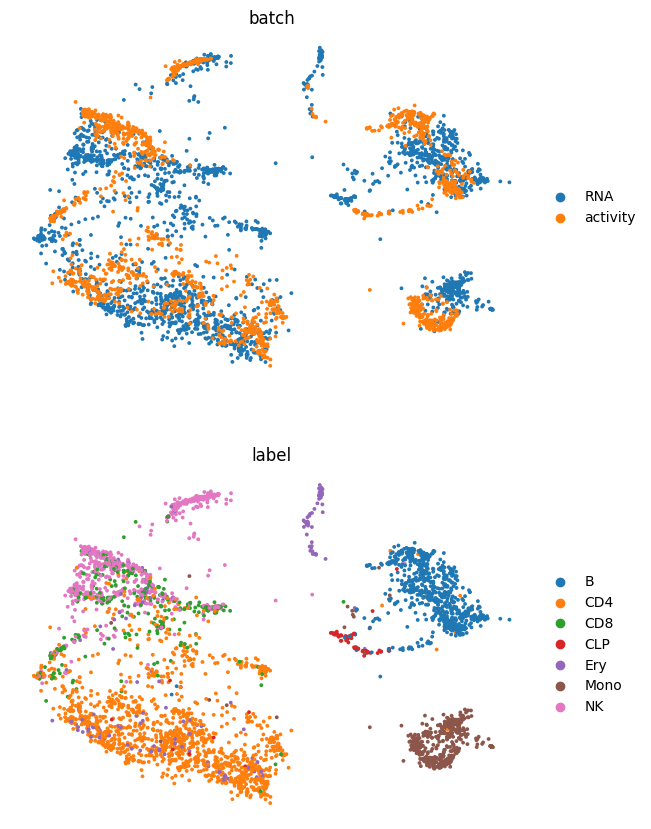

In [31]:
adata.obs['label'] = np.concatenate((basic_labels1, basic_labels2),axis=0)
sc.pl.embedding(
    adata,
    basis=SCVI_MDE_KEY,
    color=["batch",'label'],
    frameon=False,
    ncols=1,
)

In [32]:
adata.write_h5ad("/home/nas2/biod/yangchenghui/my_ych_project_BMMC/output/BMMC_scVI_adata.h5ad")

In [33]:
adata.obsm[SCVI_LATENT_KEY].shape

(3981, 30)

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Cat

[<Axes: title={'center': 'batch'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <Axes: title={'center': 'label'}, xlabel='UMAP1', ylabel='UMAP2'>]

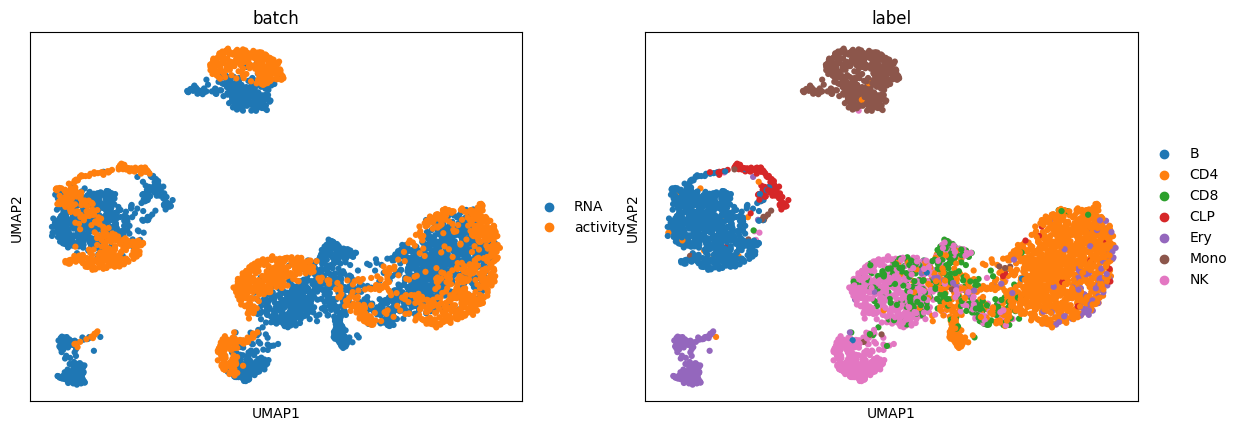

In [34]:
data_aligned = adata.obsm[SCVI_LATENT_KEY]
adata_aligned = anndata.AnnData(data_aligned).copy()
adata_aligned.obs['batch'] = np.array(['RNA'] * 2379 + ['activity'] * 1602)
adata_aligned.obs['label'] = np.concatenate((basic_labels1, basic_labels2),axis=0)
#sc.pp.scale(adata_aligned)
#sc.tl.pca(adata_aligned)
sc.pp.neighbors(adata_aligned, n_neighbors=15, n_pcs=40)
sc.tl.umap(adata_aligned)
sc.pl.umap(adata_aligned, color=['batch','label'],s = 80, show=False)

fastMNN

In [19]:
# import scanpy
# data, mnn_list, _ = scanpy.external.pp.mnn_correct(adata_aligned, batch_key='batch', k= 20)
# adata_aligned = data[0]

In [ ]:
# sc.pp.neighbors(adata_aligned, n_neighbors=15, n_pcs=40)
# sc.tl.umap(adata_aligned)
# sc.pl.umap(adata_aligned, color=['batch', 'label'],s = 80)

calculate cost

In [49]:
X1 = adata.obsm[SCVI_MDE_KEY][:2379]
X2 = adata.obsm[SCVI_MDE_KEY][2379:]
X1.shape, X2.shape

((2379, 2), (1602, 2))

In [51]:
X1 = adata.obsm[SCVI_LATENT_KEY][:2379]
X2 = adata.obsm[SCVI_LATENT_KEY][2379:]
X1.shape, X2.shape

((2379, 30), (1602, 30))

In [37]:
cell_names1 = list(RNA_counts.columns)
cell_names2 = list(activity_counts.columns)

In [52]:
import sys
sys.path.insert(1, '/home/nas2/biod/yangchenghui/FGOT-master')
from FGOT import preprocess as pre
cell_Cor = pre.calculate_cell_similarity_byMNN(X1,X2,cell_names1,cell_names2,scale=0,knn = 100)
r_pca = pre.check_mnn_accuracy(cell_Cor, basic_labels1, basic_labels2)
print("正确率为：", r_pca)

the number of MNN pairs is  81613
正确率为： 0.775195799618706


Text(0.5, 1.0, 'cost across modality')

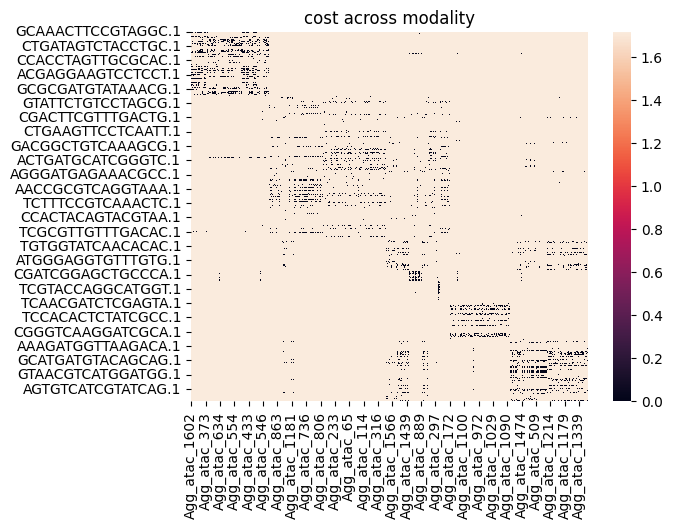

In [39]:
cost = np.array(np.exp(1 - cell_Cor)) - 1
cost = pd.DataFrame(cost, index = cell_names1, columns=cell_names2)
sorted_cols = np.argsort(basic_labels1)
sorted_cost = cost.iloc[sorted_cols,: ]
sorted_rows = np.argsort(basic_labels2)
sorted_cost = sorted_cost.iloc[:, sorted_rows]
sns.heatmap(sorted_cost)
plt.title('cost across modality')

In [40]:
# 检查是否有某一行全最大值
df = sorted_cost
all_zero_rows = (df == np.max(sorted_cost)).all(axis=1)

if any(all_zero_rows):
    print("存在某一行全为最大值的情况。")
    zero_row_indices = all_zero_rows[all_zero_rows].index.tolist()
    print(f"全为最大值的行的索引: {zero_row_indices}")
else:
    print("没有任何行全为0。")
print("全为最大值的行的个数为：",len(zero_row_indices))

存在某一行全为最大值的情况。
全为最大值的行的索引: ['ATAGACCGTAGCGTAG.1', 'TCTGAGAAGCATCATC.1', 'GGCTCGAGTTAAGACA.1', 'AGTTGGTCAGCTCGCA.1', 'AGTCTTTCAACTGCTA.1', 'ATCCACCAGTGGTAGC.1', 'GGTATTGTCTACGAGT.1', 'CGTAGGCAGGCAAAGA.1', 'GGGTCTGAGGCAATTA.1', 'ATGCGATAGTCTTGCA.1', 'GGGATGAAGACCGGAT.1', 'AGGTCATTCCTCGCAT.1', 'GGAACTTGTGATGATA.1', 'GCTTGAAGTCTCTTAT.1', 'ACTTTCACACCGAATT.1', 'GCTTCCAAGATGGGTC.1', 'ACTGTCCAGGGCTTGA.1', 'CTCGGGAAGTCATCCA.1', 'AGGGATGGTTAGGGTG.1', 'CTCACACCAATCGGTT.1', 'AGCTTGATCGCCTGAG.1', 'GGACGTCTCGTTTGCC.1', 'CTCATTATCAGTTGAC.1', 'CTGCCTACAATGACCT.1', 'ATTGGACGTAGGACAC.1', 'TCAGGATTCCGTCATC.1', 'CCTATTATCGCCAGCA.1', 'CATCAAGCAATTCCTT.1', 'TACCTTAGTCAGCTAT.1', 'TACCTTAGTGCAACGA.1', 'CCTCTGACAGGAATGC.1', 'CAGCTAACAGGCGATA.1', 'CAGCGACAGTATCGAA.1', 'CAGCATATCTGTCAAG.1', 'CGAACATAGGAGCGAG.1', 'CGAACATCACATTAGC.1', 'GTGTTAGTCTCCGGTT.1', 'GTTACAGTCTCGTATT.1', 'CCCAGTTTCTGCGTAA.1', 'GTTCGGGAGGATGGTC.1', 'CCACCTAGTTGCGCAC.1', 'CATGCCTCATTCTCAT.1', 'GTGCATAGTTGAGTTC.1', 'GTTTCTACAGGAATCG.1', 'TAG

In [41]:
# import snn
snn1 = pd.read_csv("/home/nas2/biod/hezhentao/FGOT_Project/BMMC_Zhang/BMMC_rna_snn.txt", sep='\t',index_col=0)
snn2 = pd.read_csv("/home/nas2/biod/hezhentao/FGOT_Project/BMMC_Zhang/atac/BMMC_atac_gene_acitivity_snn_k5.txt", sep='\t',index_col=0)

In [42]:
S_new = pre.smooth_cell_similarity_byLaplacian2(cell_Cor,snn1,snn2)
S_new = S_new/np.max(S_new) + cell_Cor/np.max(cell_Cor)

In [43]:
cost = np.array(np.exp(np.max(S_new) - S_new))
cost = cost - np.min(cost)
cost = pd.DataFrame(cost, index = cell_names1, columns=cell_names2)

Text(0.5, 1.0, 'cost across modality')

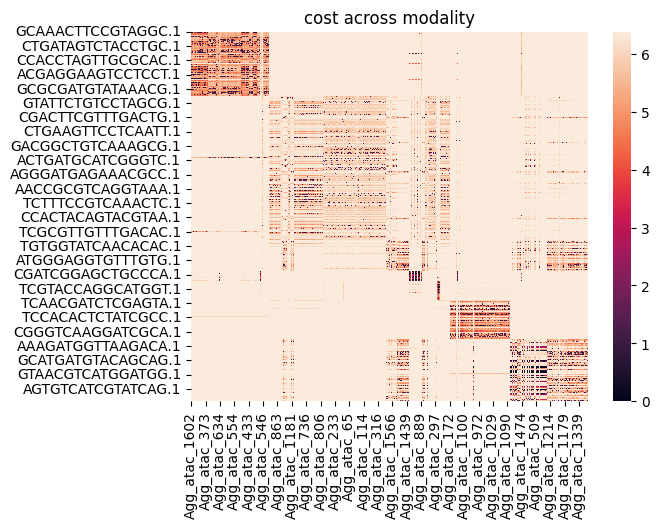

In [44]:
sorted_cols = np.argsort(basic_labels1)
sorted_cost = cost.iloc[sorted_cols,: ]
sorted_rows = np.argsort(basic_labels2)
sorted_cost = sorted_cost.iloc[:, sorted_rows]
sns.heatmap(sorted_cost)
plt.title('cost across modality')

In [48]:
cell_Cor.to_csv('/home/nas2/biod/yangchenghui/my_ych_project_BMMC/output/cell_Cor_scVIlatent.txt', sep='\t')